In [2]:
LABELS = {
    "Salinas": [
        "Undefined",
        "Brocoli_green_weeds_1",
        "Brocoli_green_weeds_2",
        "Fallow",
        "Fallow_rough_plow",
        "Fallow_smooth",
        "Stubble",
        "Celery",
        "Grapes_untrained",
        "Soil_vinyard_develop",
        "Corn_senesced_green_weeds",
        "Lettuce_romaine_4wk",
        "Lettuce_romaine_5wk",
        "Lettuce_romaine_6wk",
        "Lettuce_romaine_7wk",
        "Vinyard_untrained",
        "Vinyard_vertical_trellis",
    ],

    'IndianPines': [
        "Undefined",
        "Alfalfa",
        "Corn-notill",
        "Corn-mintill",
        "Corn",
        "Grass-pasture",
        "Grass-trees",
        "Grass-pasture-mowed",
        "Hay-windrowed",
        "Oats",
        "Soybean-notill",
        "Soybean-mintill",
        "Soybean-clean",
        "Wheat",
        "Woods",
        "Buildings-Grass-Trees-Drives",
        "Stone-Steel-Towers",
    ]}

In [3]:
import torch
import models
import os
import numpy as np
import matplotlib.pyplot as plt


    # device = kwargs.setdefault("device", torch.device("cpu"))
    # n_classes = kwargs["n_classes"]
    # n_bands = kwargs["n_bands"]
    # weights = torch.ones(n_classes)
    # weights[torch.LongTensor(kwargs["ignored_labels"])] = 0.0
    # weights = weights.to(device)
    # weights = kwargs.setdefault("weights", weights)

import scipy.io 
from models import test
# Load the model
# Assuming your model is already loaded and named 'model'

def run_inference(data, model, hyperparams, gt):
    # Preprocess the data as needed
    # For example, reshape the data and normalize it
    data = data.astype(np.float32)  # Convert to float32
    # data /= np.max(data)            # Normalize to [0, 1]

    # Perform inference
    # Assuming your model takes input of shape [batch_size, channels, height, width]
    # You may need to adjust this depending on your model's input requirements
    input_tensor = torch.tensor(data)#.unsqueeze(0).unsqueeze(0)  # Assuming single channel input
    with torch.no_grad():
        hyperparams['test_stride'] = 1
        output = test(model, input_tensor, hyperparams)
        predicted_classes = np.argmax(output, axis=-1)
        mask = np.zeros(gt.shape, dtype="bool")
        for label in hyperparams['ignored_labels']:
            mask[gt == label] = True
        predicted_classes[mask] = 0
        return predicted_classes

def load_model(ds, dr, n_comps, model_name, class_balancing=False, epoch=30):
    hyperparams = {'dataset': f'{ds}_{dr}_{n_comps}', 'model': model_name, 'cuda': 0, 'training_sample': 0.5, 'epoch': epoch,
                'patch_size': 7, 'class_balancing': class_balancing, 'n_classes': len(LABELS[ds]), 'ignored_labels': [0],
                'n_bands': n_comps, 'device': 'cuda'
                }

    model, optimizer, loss, hyperparams = models.get_model(model_name, **hyperparams)
    # Define the directory path
    if class_balancing:
        directory = f'./checkpoints/{model_name}_et_al/class_balancing/{ds}_{dr}_{n_comps}/best_model'
    else:
        directory = f'./checkpoints/{model_name}_et_al/no_class_balancing/{ds}_{dr}_{n_comps}/best_model'
        

    # substring = f'epoch{epoch}'

    # # Filter files to find the ones containing the substring
    # matching_files = [file for file in os.listdir(directory) if substring in file]

    # # Take the last matching file
    # if matching_files:
    #     last_matching_file = matching_files[-1]
    #     model.load_state_dict(torch.load(os.path.join(directory, last_matching_file)))
    #     return model, hyperparams

    model.load_state_dict(torch.load(os.path.join(directory, 'best_model.pth')))
    return model, hyperparams

def plot_single_inference(ds, dr, n_comps, predicted_classes, model_name):
    # Get the class labels from LABELS dictionary
    labels = LABELS[ds]
    # Create a colormap based on the number of classes
    num_classes = len(labels)
    cmap = plt.cm.get_cmap('tab20', num_classes)  # Exclude black for the first class
    colors = ['black'] + [cmap(i) for i in range(num_classes -1)]

    plt.figure(figsize=(10, 5))
    plt.imshow(predicted_classes, cmap=plt.cm.colors.ListedColormap(colors), interpolation='nearest')

    patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(0, num_classes)]
    plt.legend(patches, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Class Labels')

    # Set plot title and axis labels
    if model_name == 'Ground Truth':
        plt.title(f'{ds} Ground Truth')
    else:
        plt.title(f'Inference with {model_name}_{dr}_{n_comps}')
    plt.xlabel('Width')
    plt.ylabel('Height')

    # Show plot
    plt.show()

def plot_all_inference(ds, dr, n_comps, outputs):
    """
    Plot predicted classes for multiple models with categorical legend beside the last plot.
    
    Parameters:
        ds (str): Dataset identifier to fetch class labels from LABELS dictionary.
        dr (str): DR method.
        n_comps (int): Number of components.
        outputs (dict): Dictionary containing outputs for each model.
    """
    # Get the class labels from LABELS dictionary
    labels = LABELS[ds]
    
    # Create a colormap based on the number of classes
    num_classes = len(labels)
    cmap = plt.cm.get_cmap('tab20', num_classes)  # Exclude black for the first class
    colors = ['black'] + [cmap(i) for i in range(num_classes -1)]
    
    # Number of models
    num_models = len(outputs)
    fig, axes = plt.subplots(1, num_models + 1, figsize=(5*(num_models + 1), 5))

    # Plot for each model
    for i, (model_name, output) in enumerate(outputs.items()):
        ax = axes[i] if num_models > 1 else axes  # Handle single model case
        im = ax.imshow(output, cmap=plt.cm.colors.ListedColormap(colors), interpolation='nearest')

        # Set plot title and axis labels
        if model_name == 'Ground Truth':
            ax.set_title(model_name)
        else:
            ax.set_title(f'Inference with {model_name}_{dr}_{n_comps}')
        # ax.set_xlabel('Width')
        # ax.set_ylabel('Height')

    # Create categorical legend subplot
    ax_legend = axes[-1]
    ax_legend.axis('off')
    patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(num_classes)]
    ax_legend.legend(patches, labels, loc='center', title='Class Labels', ncol=1)

    plt.subplots_adjust(wspace=0.3)  # Adjust space between subplots
    plt.tight_layout()
    plt.show()

Using IndianPines_PCA_8 dataset with shape (145, 145, 8)


Inference on the image: 194it [00:00, 198.71it/s]                         
Inference on the image: 194it [00:01, 176.10it/s]                         
C:\Users\Dell\AppData\Local\Temp\ipykernel_17880\2754959705.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)  # Exclude black for the first class


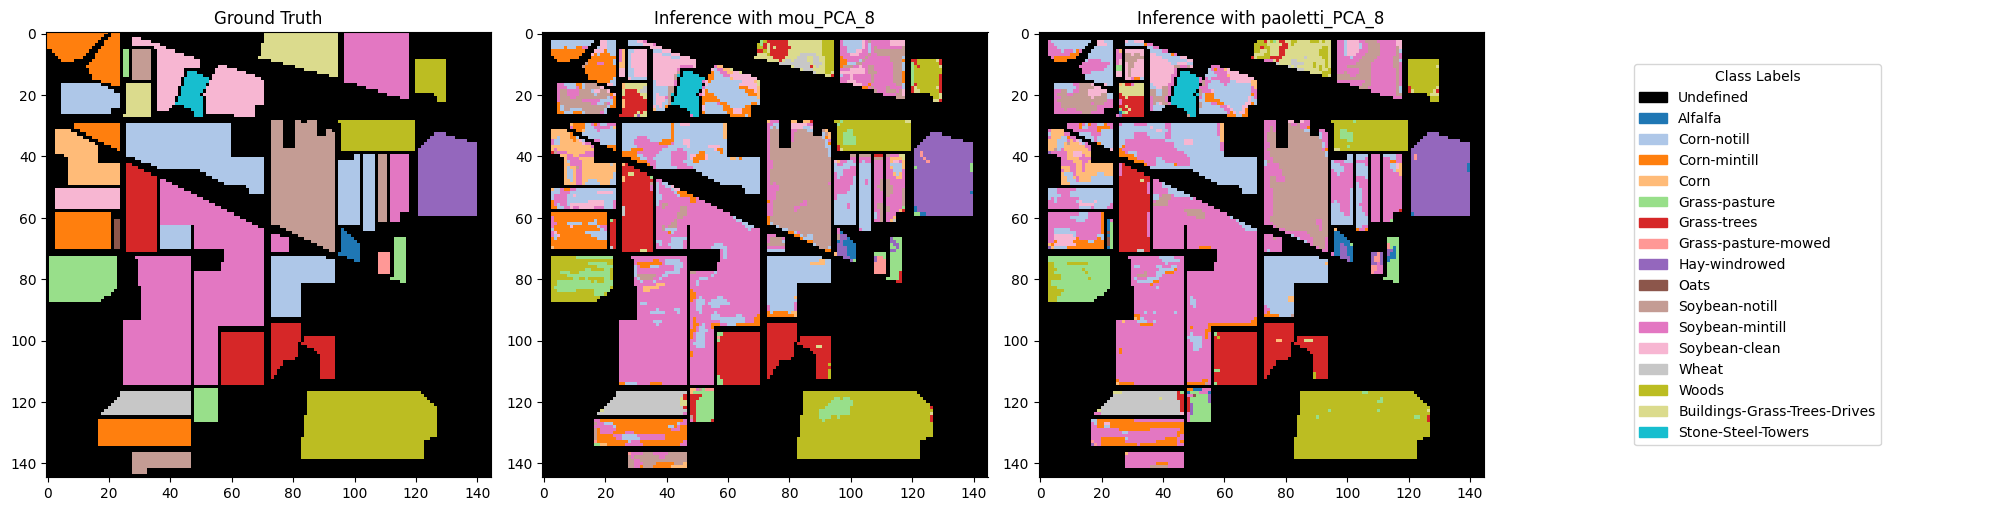

In [7]:
class_balancing = False
epoch = 30
ds = 'IndianPines'
dr = 'PCA'
n_comps = 8


if ds == 'Salinas':
    ground_truth = scipy.io.loadmat(f'./Datasets/{ds}/Salinas_gt.mat')['salinas_gt']
elif ds == 'IndianPines':
    ground_truth = scipy.io.loadmat(f'./Datasets/{ds}/Indian_pines_gt.mat')['indian_pines_gt']

# data = scipy.io.loadmat(f'./Datasets/{ds}/{ds}_{dr}_{n_comps}.mat')['data']
from datasets import get_dataset
img, gt, LABEL_VALUES, IGNORED_LABELS, RGB_BANDS, palette = get_dataset(f'{ds}_{dr}_{n_comps}', f'./Datasets/{ds}/')

classifications = {'Ground Truth': gt}
# for model_name in ['li', 'hamida', 'mou', 'paoletti']:
for model_name in ['mou', 'paoletti']:
    model, hyperparams = load_model(ds, dr, n_comps, model_name)
    # print(hyperparams)
    classifications[model_name] = run_inference(img, model, hyperparams, gt)

plot_all_inference(ds, dr, n_comps, classifications)

C:\Users\Dell\AppData\Local\Temp\ipykernel_17880\2754959705.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)  # Exclude black for the first class


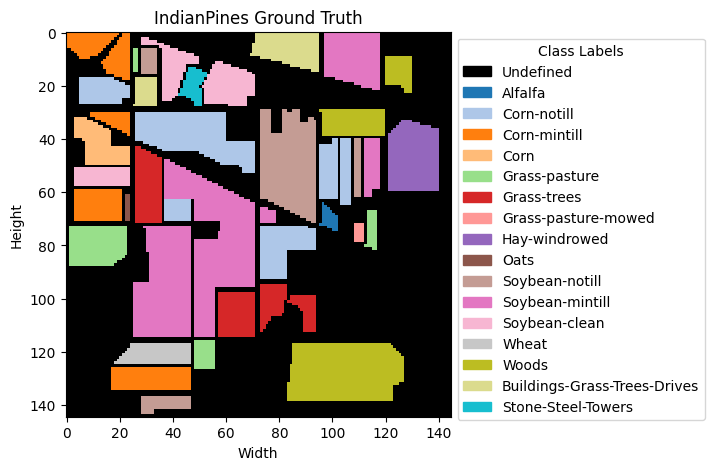

In [8]:

model_name = 'Ground Truth'
plot_single_inference(ds, dr, n_comps, classifications[model_name], model_name)

C:\Users\Dell\AppData\Local\Temp\ipykernel_17880\2754959705.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)  # Exclude black for the first class


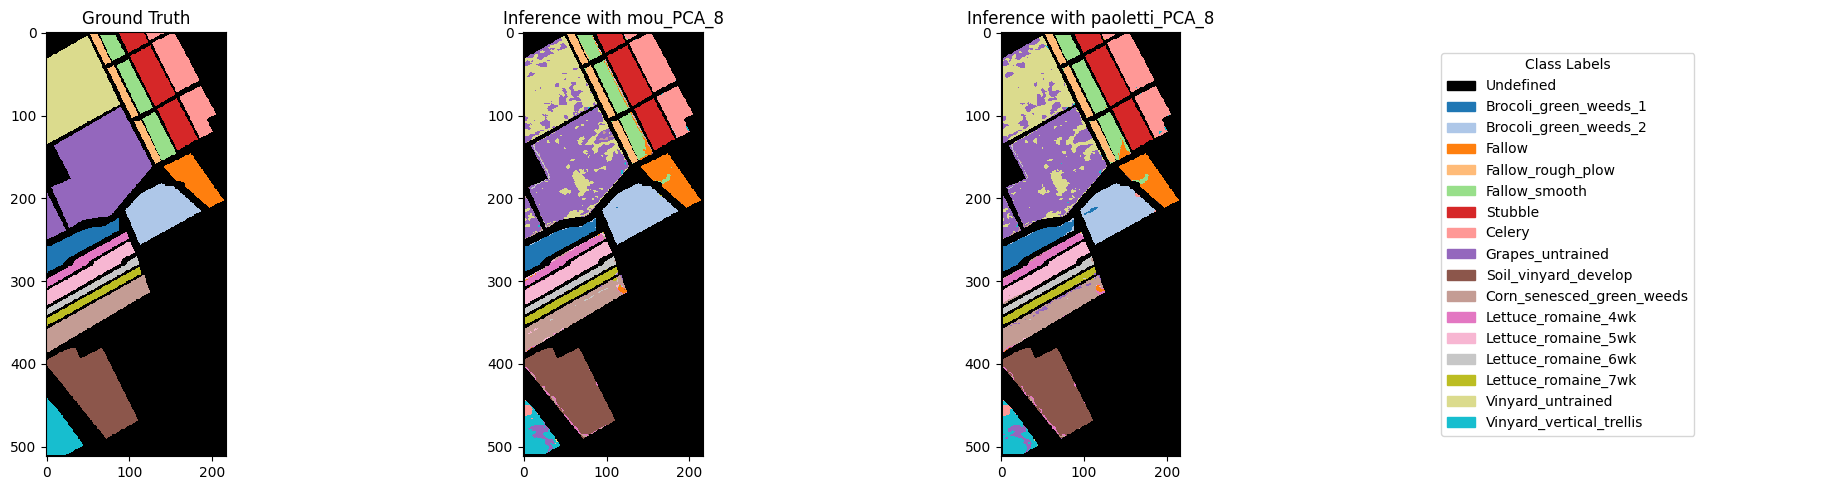

In [6]:
plot_all_inference(ds, dr, n_comps, classifications)